In [1]:
%%time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
%matplotlib inline

CPU times: total: 2.86 s
Wall time: 3.21 s


In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root=r"C:\Users\akhil\Downloads\data",train=True,download=True,transform = transform)

In [4]:
test_data = datasets.MNIST(root=r"C:\Users\akhil\Downloads\data",train=False,download=True,transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\akhil\Downloads\data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\akhil\Downloads\data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [8]:
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)


In [9]:
for i,(X_train,y_train) in enumerate(train_data):
    break

In [10]:
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [11]:
x = F.relu(conv1(x))

In [12]:
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
x = F.max_pool2d(x,2,2)

In [14]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [15]:
class Convolutional_Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [16]:
model = Convolutional_Network()
model
torch.manual_seed(42)
PATH = "model.pt"

# Save
torch.save(model.state_dict(), PATH)

# Load
device = torch.device('cuda')
model = Convolutional_Network()
model.load_state_dict(torch.load(PATH))
model.to(device)
model

Convolutional_Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)


In [19]:
import time 
start_time = time.time()

epochs = 5
train_losses = list()
test_losses = list()

train_correct = list()
test_correct = list()

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred.to(device),y_train.to(device))
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted.to(device)==y_train.to(device)).sum()
        trn_corr +=batch_corr 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test.to(device))
            predicted = torch.max(y_val.data,1)[1]
            tst_corr+=(predicted.to(device)==y_test.to(device)).sum()
            
    loss = criterion(y_val.to(device),y_test.to(device))
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
        
        
        
current_time = time.time()
total = current_time - start_time

print(f"Training time : {total/60} Minutes")

Epoch: 0 Batch: 600 Loss: 0.04569999501109123
Epoch: 0 Batch: 1200 Loss: 0.12213385105133057
Epoch: 0 Batch: 1800 Loss: 0.43774667382240295
Epoch: 0 Batch: 2400 Loss: 0.02973116934299469
Epoch: 0 Batch: 3000 Loss: 0.014215173199772835
Epoch: 0 Batch: 3600 Loss: 0.002578600775450468
Epoch: 0 Batch: 4200 Loss: 0.7643004655838013
Epoch: 0 Batch: 4800 Loss: 0.02339652180671692
Epoch: 0 Batch: 5400 Loss: 0.013595720753073692
Epoch: 0 Batch: 6000 Loss: 0.0407630018889904
Epoch: 1 Batch: 600 Loss: 0.0036060456186532974
Epoch: 1 Batch: 1200 Loss: 0.14163783192634583
Epoch: 1 Batch: 1800 Loss: 0.0007603481644764543
Epoch: 1 Batch: 2400 Loss: 0.014107969589531422
Epoch: 1 Batch: 3000 Loss: 0.1870981752872467
Epoch: 1 Batch: 3600 Loss: 0.00019010524556506425
Epoch: 1 Batch: 4200 Loss: 3.58924335159827e-05
Epoch: 1 Batch: 4800 Loss: 0.000810155353974551
Epoch: 1 Batch: 5400 Loss: 0.0010506249964237213
Epoch: 1 Batch: 6000 Loss: 0.30357858538627625
Epoch: 2 Batch: 600 Loss: 0.006705217994749546
Epo

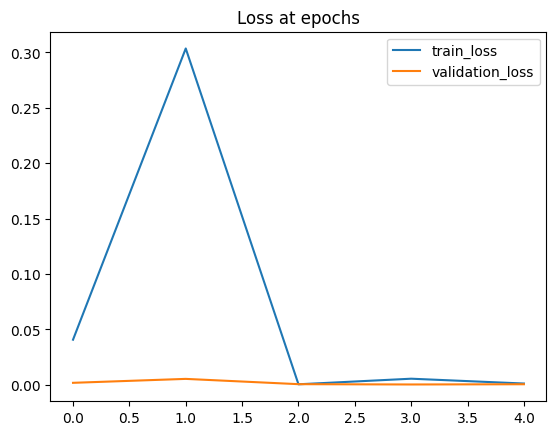

In [20]:
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='validation_loss')
plt.title('Loss at epochs')
plt.legend()

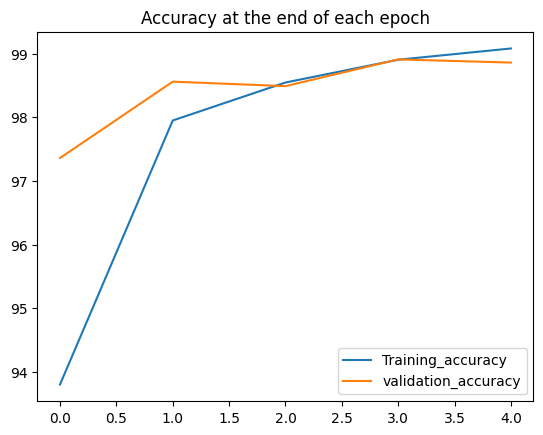

In [21]:
plt.plot([t.to('cpu')/600 for t in train_correct],label='Training_accuracy')
plt.plot([t.to('cpu')/100 for t in test_correct],label='validation_accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [23]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test.to(device))
        predicted = torch.max(y_val.to(device),1)[1]
        correct+= (predicted.to(device) == y_test.to(device)).sum()

In [24]:
correct.item()/len(test_data)

0.9848

In [22]:
import requests